# image paths

Let's double check on the image paths, and the output of the notebook that Murilo put together.

In [1]:
%load_ext autoreload
%autoreload 2

## testing spark setup

In [2]:
# let's check that the initial data from murilo is theres
! gcloud storage ls gs://dsgt-clef-snakeclef-2024/data/parquet_files/image_data | head

gs://dsgt-clef-snakeclef-2024/data/parquet_files/image_data/
gs://dsgt-clef-snakeclef-2024/data/parquet_files/image_data/_SUCCESS
gs://dsgt-clef-snakeclef-2024/data/parquet_files/image_data/part-00000-7c5726db-c4fb-44e6-9378-0038763e7673-c000.snappy.parquet
gs://dsgt-clef-snakeclef-2024/data/parquet_files/image_data/part-00003-7c5726db-c4fb-44e6-9378-0038763e7673-c000.snappy.parquet
gs://dsgt-clef-snakeclef-2024/data/parquet_files/image_data/part-00007-7c5726db-c4fb-44e6-9378-0038763e7673-c000.snappy.parquet
gs://dsgt-clef-snakeclef-2024/data/parquet_files/image_data/part-00011-7c5726db-c4fb-44e6-9378-0038763e7673-c000.snappy.parquet
gs://dsgt-clef-snakeclef-2024/data/parquet_files/image_data/part-00015-7c5726db-c4fb-44e6-9378-0038763e7673-c000.snappy.parquet
gs://dsgt-clef-snakeclef-2024/data/parquet_files/image_data/part-00019-7c5726db-c4fb-44e6-9378-0038763e7673-c000.snappy.parquet
gs://dsgt-clef-snakeclef-2024/data/parquet_files/image_data/part-00023-7c5726db-c4fb-44e6-9378-0038763

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/01/28 12:21:02 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


root
 |-- path: string (nullable = true)
 |-- folder_name: string (nullable = true)
 |-- year: string (nullable = true)
 |-- binomial_name: string (nullable = true)
 |-- file_name: string (nullable = true)
 |-- image_binary_data: binary (nullable = true)



-RECORD 0-----------------------------------------------------------------------------------------------------------------
 path              | SnakeCLEF2023-small_size/2023/Ahaetulla_prasina/252657757.jpeg                                       
 folder_name       | SnakeCLEF2023-small_size                                                                             
 year              | 2023                                                                                                 
 binomial_name     | Ahaetulla_prasina                                                                                    
 file_name         | 252657757.jpeg                                                                                       
 image_binary_data | [FF D8 FF E0 00 10 4A 46 49 46 00 01 01 00 00 01 00 01 00 00 FF E2 02 28 49 43 43 5F 50 52 4F 46 ... 
only showing top 1 row



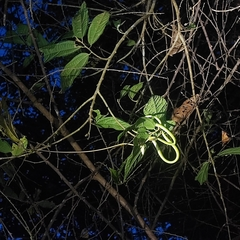

In [3]:
from snakeclef.utils import get_spark
from IPython.display import Image, display

spark = get_spark()
display(spark)

# read straight from the bucket
image_df = spark.read.parquet(
    "gs://dsgt-clef-snakeclef-2024/data/parquet_files/image_data"
)
image_df.printSchema()
image_df.show(vertical=True, n=1, truncate=100)

row = image_df.first()
display(Image(row.image_binary_data))

In [4]:
# let's test that we can write back the data to the bucket using our current configuration
test_path = (
    "gs://dsgt-clef-snakeclef-2024/data/parquet_files/acm_image_data_test_repartition"
)
(image_df.repartition(1).write.parquet(test_path, mode="overwrite"))

! gcloud storage du --readable-sizes {test_path}

0B           gs://dsgt-clef-snakeclef-2024/data/parquet_files/acm_image_data_test_repartition/
0B           gs://dsgt-clef-snakeclef-2024/data/parquet_files/acm_image_data_test_repartition/_SUCCESS
2.67MiB      gs://dsgt-clef-snakeclef-2024/data/parquet_files/acm_image_data_test_repartition/part-00000-d27ac4ca-0ce1-477b-9085-537ca11e8eff-c000.snappy.parquet
2.67MiB      gs://dsgt-clef-snakeclef-2024/data/parquet_files/acm_image_data_test_repartition/


## downloading the dataset to scratch disk

In [5]:
# first download and untar the data
! gcloud storage ls gs://dsgt-clef-snakeclef-2024/raw/

gs://dsgt-clef-snakeclef-2024/raw/SnakeCLEF2023-PubTestMetadata.csv
gs://dsgt-clef-snakeclef-2024/raw/SnakeCLEF2023-TrainMetadata-HM.csv
gs://dsgt-clef-snakeclef-2024/raw/SnakeCLEF2023-TrainMetadata-iNat.csv
gs://dsgt-clef-snakeclef-2024/raw/SnakeCLEF2023-ValMetadata.csv
gs://dsgt-clef-snakeclef-2024/raw/SnakeCLEF2023-pubtest.tar.gz
gs://dsgt-clef-snakeclef-2024/raw/SnakeCLEF2023-train-large_size.tar.gz
gs://dsgt-clef-snakeclef-2024/raw/SnakeCLEF2023-train-medium_size.tar.gz
gs://dsgt-clef-snakeclef-2024/raw/SnakeCLEF2023-train-small_size.tar.gz
gs://dsgt-clef-snakeclef-2024/raw/SnakeCLEF2023-trainHMP.tar.gz
gs://dsgt-clef-snakeclef-2024/raw/SnakeCLEF2023-val-large_size.tar.gz
gs://dsgt-clef-snakeclef-2024/raw/SnakeCLEF2023-val-medium_size.tar.gz
gs://dsgt-clef-snakeclef-2024/raw/SnakeCLEF2023-val-small_size.tar.gz
gs://dsgt-clef-snakeclef-2024/raw/urls.txt


In [6]:
# make sure the directory is mounted, and that it is writable by all
! sudo mount /mnt/data
! sudo chmod -R 777 /mnt/data

mount: /mnt/data: /dev/nvme0n1 already mounted on /mnt/data.


In [7]:
! gcloud storage cp \
    gs://dsgt-clef-snakeclef-2024/raw/SnakeCLEF2023-train-small_size.tar.gz \
    /mnt/data
! ls /mnt/data

Copying gs://dsgt-clef-snakeclef-2024/raw/SnakeCLEF2023-train-small_size.tar.gz to file:///mnt/data/SnakeCLEF2023-train-small_size.tar.gz
  Completed files 1/1 | 4.5GiB/4.5GiB | 49.9MiB/s                              

Average throughput: 373.8MiB/s
SnakeCLEF2023-small_size  SnakeCLEF2023-train-small_size.tar.gz  lost+found


In [8]:
# untar the data
! tar -xzf /mnt/data/SnakeCLEF2023-train-small_size.tar.gz -C /mnt/data
! ls /mnt/data

SnakeCLEF2023-small_size  SnakeCLEF2023-train-small_size.tar.gz  lost+found


In [9]:
! df -h

Filesystem      Size  Used Avail Use% Mounted on
/dev/root        49G   35G   14G  72% /
tmpfs           7.4G     0  7.4G   0% /dev/shm
tmpfs           3.0G 1020K  3.0G   1% /run
tmpfs           5.0M     0  5.0M   0% /run/lock
/dev/sda15      105M  6.1M   99M   6% /boot/efi
tmpfs           1.5G  8.0K  1.5G   1% /run/user/1001
/dev/nvme0n1    369G  9.4G  340G   3% /mnt/data


## checking for difference between image paths

In [10]:
from pathlib import Path
from pyspark.sql import functions as F

raw_root = "gs://dsgt-clef-snakeclef-2024/raw/"

train_meta_hm = spark.read.csv(
    f"{raw_root}/SnakeCLEF2023-TrainMetadata-HM.csv", header=True, inferSchema=True
)
train_meta_inat = spark.read.csv(
    f"{raw_root}/SnakeCLEF2023-TrainMetadata-iNat.csv", header=True, inferSchema=True
)

train_meta_hm.printSchema()
train_meta_inat.printSchema()

root
 |-- observation_id: string (nullable = true)
 |-- binomial_name: string (nullable = true)
 |-- image_path: string (nullable = true)
 |-- subset: string (nullable = true)
 |-- code: string (nullable = true)
 |-- endemic: boolean (nullable = true)
 |-- class_id: integer (nullable = true)

root
 |-- observation_id: integer (nullable = true)
 |-- endemic: boolean (nullable = true)
 |-- binomial_name: string (nullable = true)
 |-- code: string (nullable = true)
 |-- image_path: string (nullable = true)
 |-- class_id: integer (nullable = true)
 |-- subset: string (nullable = true)



In [11]:
meta_df = (
    (
        # make this table consistent with the inat one
        train_meta_hm.withColumn(
            "observation_id", F.split("observation_id", " ")[1].cast("int")
        ).select(train_meta_inat.columns)
    )
    .union(train_meta_inat)
    .dropDuplicates()
    .repartition(1)
).cache()
meta_df.show()

+--------------+-------+--------------------+----+--------------------+--------+--------+
|observation_id|endemic|       binomial_name|code|          image_path|class_id|  subset|
+--------------+-------+--------------------+----+--------------------+--------+--------+
|         42265|   true|     Liodytes pygaea|  US|HMP/Liodytes_pyga...|     933|train-hm|
|        317846|   true|     Liodytes pygaea|  US|HMP/Liodytes_pyga...|     933|train-hm|
|        325731|   true|       Crotalus enyo|  MX|HMP/Crotalus_enyo...|     414|train-hm|
|        114227|  false|  Contia longicaudae|  US|HMP/Contia_longic...|     378|train-hm|
|        128559|  false|  Contia longicaudae|  US|HMP/Contia_longic...|     378|train-hm|
|        375354|  false|  Contia longicaudae|  US|HMP/Contia_longic...|     378|train-hm|
|        127773|   true|      Micrurus tener|  US|HMP/Micrurus_tene...|    1082|train-hm|
|        280822|  false| Dendrelaphis pictus|  ID|HMP/Dendrelaphis_...|     499|train-hm|
|        3

In [12]:
# check if there are duplicate ids
print(meta_df.count())
print(meta_df.groupBy("observation_id").count().where("count > 1").count())

# check if there are duplicate paths?
meta_df.groupBy("image_path").count().where("count > 1").show()

168139
34847
+----------+-----+
|image_path|count|
+----------+-----+
+----------+-----+



In [13]:
# let's grab all the paths
train_root = Path("/mnt/data/SnakeCLEF2023-small_size")
paths = [p.relative_to(train_root) for p in train_root.glob("**/*.jpg")]
len(paths), paths[:10]

(68495,
 [PosixPath('1992/Lampropeltis_annulata/70994554.jpg'),
  PosixPath('1992/Lampropeltis_annulata/70996911.jpg'),
  PosixPath('1992/Lampropeltis_annulata/70996944.jpg'),
  PosixPath('1992/Lampropeltis_annulata/70994517.jpg'),
  PosixPath('1992/Lampropeltis_annulata/2666585.jpg'),
  PosixPath('1992/Sistrurus_tergeminus/23760401.jpg'),
  PosixPath('1992/Drymarchon_couperi/237898.jpg'),
  PosixPath('1992/Ophiophagus_hannah/59128457.jpg'),
  PosixPath('1992/Lampropeltis_alterna/1815419.jpg'),
  PosixPath('1992/Eunectes_murinus/279381.jpg')])

In [14]:
from pyspark.sql import Row

path_df = spark.createDataFrame([Row(path=p.as_posix()) for p in paths])
path_df.show(n=5, truncate=100)

+---------------------------------------+
|                                   path|
+---------------------------------------+
|1992/Lampropeltis_annulata/70994554.jpg|
|1992/Lampropeltis_annulata/70996911.jpg|
|1992/Lampropeltis_annulata/70996944.jpg|
|1992/Lampropeltis_annulata/70994517.jpg|
| 1992/Lampropeltis_annulata/2666585.jpg|
+---------------------------------------+
only showing top 5 rows



In [15]:
meta_df.select("image_path").show(n=3, truncate=False)


def remove_leading_parent(col):
    """remove the leading parent directory from the path

    e.g. 1992/Lampropeltis_annulata/70994554.jpg turns into Lampropeltis_annulata/70994554.jpg
    """
    return F.regexp_replace(col, "^(.+?)\/", "")


# let's join the two tables
joined_df = meta_df.withColumn("path", remove_leading_parent("image_path")).join(
    path_df.withColumn("path", remove_leading_parent("path")), on="path", how="right"
)

joined_df.show(n=5)

+------------------------------+
|image_path                    |
+------------------------------+
|HMP/Liodytes_pygaea/63985.jpg |
|HMP/Liodytes_pygaea/436163.jpg|
|HMP/Crotalus_enyo/448622.jpg  |
+------------------------------+
only showing top 3 rows



+--------------------+--------------+-------+--------------------+-------+--------------------+--------+------+
|                path|observation_id|endemic|       binomial_name|   code|          image_path|class_id|subset|
+--------------------+--------------+-------+--------------------+-------+--------------------+--------+------+
|Austrelaps_superb...|     136014856|   true| Austrelaps superbus|     AU|2022/Austrelaps_s...|     152| train|
|Austrelaps_superb...|     143996145|   true| Austrelaps superbus|     AU|2022/Austrelaps_s...|     152| train|
|Masticophis_taeni...|      50017001|  false|Masticophis taeni...|     US|2020/Masticophis_...|    1018| train|
|Lampropeltis_annu...|       2393428|  false|Lampropeltis annu...|     US|1992/Lampropeltis...|     861| train|
|Masticophis_taeni...|      50097604|  false|Masticophis taeni...|unknown|2020/Masticophis_...|    1018| train|
+--------------------+--------------+-------+--------------------+-------+--------------------+--------+

In [16]:
# any missing rows on the left will be filled with nulls
joined_df.where("image_path is not null").count(), path_df.count()

(68495, 68495)

In [17]:
# lets check where all data is coming from
joined_df.groupby("subset").count().show()

+------+-----+
|subset|count|
+------+-----+
| train|68495|
+------+-----+

